In [ ]:
%cd "/content/drive/NLP/Notebooks/Projects/HTM(healthcare_topic_modelling)"
%ls

In [60]:
import pandas as pd
import numpy as np

from itertools import product
from functools import reduce
import matplotlib.pyplot as plt

import spacy
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse as sp

In [3]:
# Data Loading
train_df = pd.read_csv("train_df.csv")
test_df = pd.read_csv("test_df.csv")
print(train_df.head(2),"\n",train_df.columns,"\n",test_df.head(2))

                                                sent  ...                                                pos
0  All live births > or = 23 weeks at the Univers...  ...  DET ADJ NOUN X CCONJ SYM NUM NOUN ADP DET PROP...
1  The total cesarean rate was 14.4 % ( 344 of 23...  ...  DET ADJ ADJ NOUN AUX NUM NOUN PUNCT NUM ADP NU...

[2 rows x 4 columns] 
 Index(['sent', 'labels', 'noun', 'pos'], dtype='object') 
                                                 sent                                             labels
0  Furthermore , when all deliveries were analyze...  O O O O O O O O O O O O O O O O O O O O O O O ...
1  As the ambient temperature increases , there i...             O O O O O O O O O O O O O O O O O O O 


In [ ]:
train_df.iloc[4]['sent'], train_df.iloc[4]['pos']

("Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively ) ",
 'NOUN ADP NOUN AUX DET ADV ADJ NOUN ADP DET PUNCT PUNCT VERB PUNCT NOUN PUNCT NUM CCONJ NUM NOUN PUNCT ADV PUNCT')

### Implementation of HMM #1

In [ ]:
# Loading nlp model from spacy for ner tag
nlp = spacy.load("en_core_web_sm")

In [ ]:
def ner(sent):
  doc = nlp(sent)
  snt_ls = []
  pos_ls = []
  comb_ind = []
  punct_cnt = 0
  for ind,token in enumerate(doc):
    # Skipped the tag as well as text when text = `` as this is counted as two POS token/tag
    if token.text =="`":
      punct_cnt += 1
      continue
    # To store the location of text joined with "-" as those texts are as one words in sentence but three in POS tags
    if token.text == "-":
      # print(f"{ind}, {doc[ind-1:ind+2]}, {token.text} ------  {token.pos_}")
      comb_ind.append(ind)
    else:
      snt_ls.append(token.text)
      pos_ls.append(token.pos_)
  if len(comb_ind) != 0:
    for c_ind in comb_ind:
      c_ind = c_ind-punct_cnt
      # Combined the POS tags joined by "-"
      snt_ls = snt_ls[:c_ind+1]+ ["-".join(snt_ls[c_ind+1:c_ind+3])] + snt_ls[c_ind+3:]
      pos_ls = pos_ls[:c_ind+1]+ ["-".join(pos_ls[c_ind+1:c_ind+3])] + pos_ls[c_ind+3:]
  return snt_ls, pos_ls

In [ ]:
train_sent = []
pos_list = []
for s_ind,sent in enumerate(train_df.sent.iloc[:5]):
  (new_ls, new_pos_ls) = ner(sent.lower())
  train_sent.extend(new_ls)
  pos_list.extend(new_pos_ls)
  # print(len(new_ls), len(new_pos_ls))

In [ ]:
len(train_sent), len(pos_list)

(142, 142)

In [ ]:
emmission_matrix = pd.crosstab(np.array(train_sent),np.array(pos_list),normalize='columns')
emmission_matrix.columns = map(str.lower, emmission_matrix.columns)
emmission_matrix

,adj,adj-adj,adp,adv,aux,cconj,det,noun,num,part,propn,punct,sym,verb,x
row_0,,,,,,,,,,,,,,,
%,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.206897,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
'',0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.103448,0.0,0.0,0.0
(,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.310345,0.0,0.0,0.0
),0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.310345,0.0,0.0,0.0
",",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.275862,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
university,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.333333,0.000000,0.0,0.0,0.0
vermont,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.333333,0.000000,0.0,0.0,0.0
was,0.0,0.0,0.0,0.0,0.857143,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [ ]:
# Verifying each column's sum should be 1.0
for col in emmission_matrix.columns:  
  print(f"{col} = {round(emmission_matrix[col].sum(),1)}")

adj = 1.0
adj-adj = 1.0
adp = 1.0
adv = 1.0
aux = 1.0
cconj = 1.0
det = 1.0
noun = 1.0
num = 1.0
part = 1.0
propn = 1.0
punct = 1.0
sym = 1.0
verb = 1.0
x = 1.0


In [ ]:
# Transition Matrix
tr_df2.head()

,adj,adp,adv,aux,cconj,det,end,noun,num,part,propn,punct,start,sym,verb
adj,0.101911,0.082353,0.064220,0.100917,0.090909,0.090592,0.092105,0.084813,0.103011,0.065217,0.065217,0.094283,0.092105,0.065217,0.094828
adp,0.074310,0.089412,0.091743,0.073394,0.081818,0.080139,0.078947,0.086785,0.072900,0.108696,0.108696,0.079238,0.078947,0.108696,0.077586
adv,0.014862,0.023529,0.055046,0.018349,0.018182,0.024390,0.026316,0.023669,0.015848,0.021739,0.021739,0.019057,0.026316,0.021739,0.017241
aux,0.046709,0.037647,0.036697,0.050459,0.040909,0.045296,0.046053,0.038462,0.050713,0.021739,0.021739,0.043129,0.046053,0.021739,0.038793
cconj,0.042463,0.042353,0.036697,0.041284,0.045455,0.041812,0.039474,0.042406,0.041204,0.043478,0.043478,0.043129,0.039474,0.043478,0.047414


In [ ]:
tr_df2.shape, emmission_matrix.shape

((15, 15), (75, 15))

In [ ]:
# %%time
trans_sent = []
trans_pos = []
trans_mat_sent_pos = []
for s_ind,sent in enumerate(train_df.sent.iloc[:5]):
  (new_ls, new_pos_ls) = ner(sent)
  new_ls = " ".join(["<S>"] + new_ls)
  new_pos_ls1 = " ".join(new_pos_ls + ["<E>"])
  trmt_sent_pos = " ".join(["<Start>"] + new_pos_ls + ["<End>"])
  trans_sent.append(new_ls)
  trans_pos.append(new_pos_ls1)
  trans_mat_sent_pos.append(trmt_sent_pos)
  # print(new_ls,new_pos_ls)

In [ ]:
trans_sent[:2], trans_pos[:2],trans_mat_sent_pos[:2]

(['<S> All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )',
  '<S> The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )'],
 ['DET ADJ NOUN X CCONJ SYM NUM NOUN ADP DET PROPN ADP PROPN ADP NUM PUNCT PROPN SYM NUM PUNCT AUX ADV VERB ADP NOUN NOUN PUNCT NOUN ADP ADJ PUNCT ADJ NOUN PUNCT NOUN PUNCT CCONJ NOUN NOUN PUNCT PART VERB NOUN NOUN PUNCT <E>',
  'DET ADJ ADJ NOUN AUX NUM NOUN PUNCT NUM ADP NUM PUNCT PUNCT CCONJ DET ADJ NOUN AUX NUM NOUN PUNCT NUM ADP NUM PUNCT <E>'],
 ['<Start> DET ADJ NOUN X CCONJ SYM NUM NOUN ADP DET PROPN ADP PROPN ADP NUM PUNCT PROPN SYM NUM PUNCT AUX ADV VERB ADP NOUN NOUN PUNCT NOUN ADP ADJ PUNCT ADJ NOUN PUNCT NOUN PUNCT CCONJ NOUN NOUN PUNCT PART VERB NOUN NOUN PUNCT <End>',
  '<Start> DET ADJ ADJ NOUN AUX NUM NOUN PUNCT NUM ADP NUM

In [ ]:
# class sklearn.feature_extraction.text.CountVectorizer: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# Convert a collection of text documents to a matrix of token counts.
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(trans_mat_sent_pos)
X.todense(), X.shape

(matrix([[ 3,  5,  1,  1,  2,  2,  1, 11,  3,  1,  3,  8,  1,  2,  2],
         [ 3,  2,  0,  2,  1,  2,  1,  4,  6,  0,  0,  5,  1,  0,  0],
         [ 2,  1,  1,  1,  0,  1,  1,  3,  3,  0,  0,  3,  1,  0,  0],
         [ 5,  2,  0,  2,  2,  2,  1,  6,  6,  0,  0,  9,  1,  0,  3],
         [ 1,  2,  2,  1,  1,  2,  1,  5,  2,  0,  0,  4,  1,  0,  1]]),
 (5, 15))

In [ ]:
vectorizer.get_feature_names()
# vectorizer.vocabulary_

['adj',
 'adp',
 'adv',
 'aux',
 'cconj',
 'det',
 'end',
 'noun',
 'num',
 'part',
 'propn',
 'punct',
 'start',
 'sym',
 'verb']

In [ ]:
X.toarray()[0].size, X.get_shape()

(15, (5, 15))

In [ ]:
Xc = (X.T * X) # this is co-occurrence matrix in sparse csr format
Xc.setdiag(0) # sometimes you want to fill same word cooccurence to 0
print(Xc.todense()) # print out matrix in dense format

[[  0  35   7  22  20  26  14  86  65   3   9  94  14   6  22]
 [ 35   0  10  16  18  23  12  88  46   5  15  79  12  10  18]
 [  7  10   0   4   4   7   4  24  10   1   3  19   4   2   4]
 [ 22  16   4   0   9  13   7  39  32   1   3  43   7   2   9]
 [ 20  18   4   9   0  12   6  43  26   2   6  43   6   4  11]
 [ 26  23   7  13  12   0   9  55  37   2   6  55   9   4  12]
 [ 14  12   4   7   6   9   0  29  20   1   3  29   5   2   6]
 [ 86  88  24  39  43  55  29   0 112  11  33 191  29  22  45]
 [ 65  46  10  32  26  37  20 112   0   3   9 125  20   6  26]
 [  3   5   1   1   2   2   1  11   3   0   3   8   1   2   2]
 [  9  15   3   3   6   6   3  33   9   3   0  24   3   6   6]
 [ 94  79  19  43  43  55  29 191 125   8  24   0  29  16  47]
 [ 14  12   4   7   6   9   5  29  20   1   3  29   0   2   6]
 [  6  10   2   2   4   4   2  22   6   2   6  16   2   0   4]
 [ 22  18   4   9  11  12   6  45  26   2   6  47   6   4   0]]


In [ ]:
Xn = (X.T * X)
# Xn = elem/x.sum() for elem in x for x in Xn.todense()
tr_df = pd.DataFrame(Xn.toarray(), columns=vectorizer.get_feature_names(), index=vectorizer.get_feature_names())
tr_df.head(2)

,adj,adp,adv,aux,cconj,det,end,noun,num,part,propn,punct,start,sym,verb
adj,48,35,7,22,20,26,14,86,65,3,9,94,14,6,22
adp,35,38,10,16,18,23,12,88,46,5,15,79,12,10,18


In [ ]:
tr_df2 = tr_df.apply(lambda x: x/x.sum(), axis=0)

In [ ]:
# tr_df2.sum(axis=0), tr_df2.sum(axis=1)
tr_df2.describe()

,adj,adp,adv,aux,cconj,det,end,noun,num,part,propn,punct,start,sym,verb
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667
std,0.061659,0.059323,0.058690,0.061857,0.060270,0.059959,0.059982,0.059429,0.062210,0.062827,0.062827,0.060426,0.059982,0.062827,0.061129
min,0.006369,0.011765,0.009174,0.004587,0.009091,0.006969,0.006579,0.010848,0.004754,0.021739,0.021739,0.008024,0.006579,0.021739,0.008621
25%,0.024416,0.028235,0.036697,0.025229,0.027273,0.027875,0.029605,0.028600,0.023772,0.021739,0.021739,0.026580,0.029605,0.021739,0.025862
50%,0.046709,0.042353,0.036697,0.041284,0.045455,0.041812,0.039474,0.042406,0.041204,0.043478,0.043478,0.043129,0.039474,0.043478,0.047414
75%,0.088110,0.085882,0.077982,0.087156,0.086364,0.085366,0.085526,0.085799,0.087956,0.065217,0.065217,0.086760,0.085526,0.065217,0.086207
max,0.199575,0.207059,0.220183,0.197248,0.195455,0.191638,0.190789,0.204142,0.198098,0.239130,0.239130,0.195587,0.190789,0.239130,0.202586


In [ ]:
# tr_df2.iloc[-3].sum(axis=0)
def calc_score(comb):
  score = 0
  for ind, pos in enumerate(comb):
    if ind != 0:
      # print(f"{exmp_sent[ind-1]} : {comb[ind-1:ind+1]}")
      prob_trans = round(tr_df2.loc[[comb[ind-1]], comb[ind]][-1],2)
      prob_emis = round(emmission_matrix.loc[[exmp_sent[ind-1]], comb[ind]][-1],2)
      score += round(prob_trans * prob_emis, 4)
      # print(prob_trans, prob_emis, score)
      # print(round(tr_df2.loc[[combination_pos1[ind-1]], combination_pos1[ind]][-1],2))
      # print(round(emmission_matrix.loc[[exmp_sent[ind-1]], combination_pos1[ind]][-1],2))
  return score

In [ ]:
emmission_matrix.loc[['arrest'], 'noun'][-1], tr_df2.loc[['noun'], 'adp'][-1]

(0.034482758620689655, 0.20705882352941177)

In [ ]:
exmp_sent = "arrest of dilation was the most common indication".split(" ")
pos_tags = tr_df2.columns
combination_pos1 = ['start','noun','adp','noun','aux','det','adv','adj','noun']
combination_pos2 = ['start','propn','adv','propn','aux','det','adj','adj','propn']

In [ ]:
# Calculating score for different combination: combination_pos1 and combination_pos2
'''
Based on the score, we can check that the first combination is the right combination
'''
score1 = calc_score(combination_pos1)
score2 = calc_score(combination_pos2)
print(score1, score2)

0.359 0.0656


### Implementation of HMM #2

https://www.mygreatlearning.com/blog/pos-tagging/

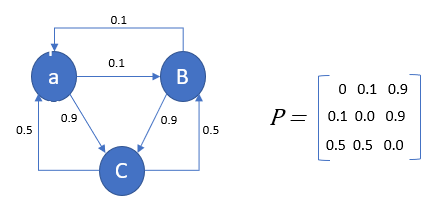

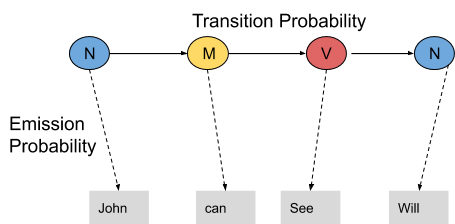

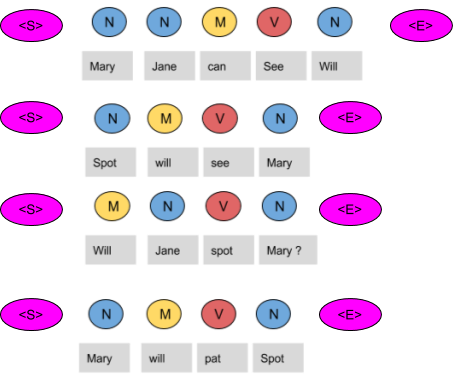

In [1]:
# Importing libraries
import nltk
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import pprint, time
 
#download the treebank corpus from nltk
nltk.download('treebank')
 
#download the universal tagset from nltk
nltk.download('universal_tagset')
 
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
 
#print the first two sentences along with tags
print(nltk_data[:2])

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')]]


In [2]:
#print each word with its respective tag for first two sentences
for sent in nltk_data[:2]:
  for tuple in sent:
    print(tuple)

('Pierre', 'NOUN')
('Vinken', 'NOUN')
(',', '.')
('61', 'NUM')
('years', 'NOUN')
('old', 'ADJ')
(',', '.')
('will', 'VERB')
('join', 'VERB')
('the', 'DET')
('board', 'NOUN')
('as', 'ADP')
('a', 'DET')
('nonexecutive', 'ADJ')
('director', 'NOUN')
('Nov.', 'NOUN')
('29', 'NUM')
('.', '.')
('Mr.', 'NOUN')
('Vinken', 'NOUN')
('is', 'VERB')
('chairman', 'NOUN')
('of', 'ADP')
('Elsevier', 'NOUN')
('N.V.', 'NOUN')
(',', '.')
('the', 'DET')
('Dutch', 'NOUN')
('publishing', 'VERB')
('group', 'NOUN')
('.', '.')


In [3]:
# split data into training and validation set in the ratio 80:20
train_set,test_set =train_test_split(nltk_data,train_size=0.80,test_size=0.20,random_state = 101)

In [4]:
# create list of train and test tagged words
train_tagged_words = [ tup for sent in train_set for tup in sent ]
test_tagged_words = [ tup for sent in test_set for tup in sent ]
print(len(train_tagged_words))
print(len(test_tagged_words))

80310
20366


In [5]:
# check some of the tagged words.
train_tagged_words[:5]

[('Drink', 'NOUN'),
 ('Carrier', 'NOUN'),
 ('Competes', 'VERB'),
 ('With', 'ADP'),
 ('Cartons', 'NOUN')]

In [6]:
#use set datatype to check how many unique tags are present in training data
tags = {tag for word,tag in train_tagged_words}
print(len(tags))
print(tags)
 
# check total words in vocabulary
vocab = {word for word,tag in train_tagged_words}

12
{'DET', 'ADP', 'ADV', 'PRT', 'NOUN', 'X', 'VERB', '.', 'CONJ', 'NUM', 'ADJ', 'PRON'}


In [7]:
# compute Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)#total number of times the passed tag occurred in train_bag
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    #now calculate the total number of times the passed word occurred as the passed tag.
    count_w_given_tag = len(w_given_tag_list)
    return (count_w_given_tag, count_tag)

# compute  Transition Probability
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
     
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                 
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
             
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

#modified Viterbi to include rule based tagger in it
def Viterbi_rule_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                 
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
             
        pmax = max(p)
        state_max = rule_based_tagger.tag([word])[0][1]       
        
         
        if(pmax==0):
            state_max = rule_based_tagger.tag([word])[0][1] # assign based on rule based tagger
        else:
            if state_max != 'X':
                # getting state for which probability is maximum
                state_max = T[p.index(pmax)]                
             
         
        state.append(state_max)
    return list(zip(words, state))

In [8]:
# creating t x t transition matrix of tags, t= no of tags
# Matrix(i, j) represents P(jth tag after the ith tag)
 
tags_matrix = np.zeros((len(tags), len(tags)), dtype='float32')
for i, t1 in enumerate(list(tags)):
    for j, t2 in enumerate(list(tags)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]
 
print(tags_matrix)

[[6.03708485e-03 9.91806854e-03 1.20741697e-02 2.87480245e-04
  6.35906279e-01 4.51343954e-02 4.02472317e-02 1.73925534e-02
  4.31220367e-04 2.28546783e-02 2.06410810e-01 3.30602261e-03]
 [3.20931405e-01 1.69577319e-02 1.45532778e-02 1.26550242e-03
  3.23588967e-01 3.45482156e-02 8.47886596e-03 3.87243740e-02
  1.01240189e-03 6.32751212e-02 1.07061505e-01 6.96026310e-02]
 [7.13731572e-02 1.19472459e-01 8.14584941e-02 1.47401085e-02
  3.21955010e-02 2.28859577e-02 3.39022487e-01 1.39255241e-01
  6.98215654e-03 2.98681147e-02 1.30721495e-01 1.20248254e-02]
 [1.01369865e-01 1.95694715e-02 9.39334650e-03 1.17416831e-03
  2.50489235e-01 1.21330721e-02 4.01174158e-01 4.50097844e-02
  2.34833662e-03 5.67514673e-02 8.29745606e-02 1.76125243e-02]
 [1.31063312e-02 1.76826611e-01 1.68945398e-02 4.39345129e-02
  2.62344331e-01 2.88252197e-02 1.49133503e-01 2.40094051e-01
  4.24540639e-02 9.14395228e-03 1.25838192e-02 4.65906132e-03]
 [5.68902567e-02 1.42225638e-01 2.57543717e-02 1.85085520e-01
  6

In [9]:
# convert the matrix to a df for better readability
#the table is same as the transition table shown in section 3 of article
tags_df = pd.DataFrame(tags_matrix, columns = list(tags), index=list(tags))
display(tags_df)

,DET,ADP,ADV,PRT,NOUN,X,VERB,.,CONJ,NUM,ADJ,PRON
DET,0.006037,0.009918,0.012074,0.000287,0.635906,0.045134,0.040247,0.017393,0.000431,0.022855,0.206411,0.003306
ADP,0.320931,0.016958,0.014553,0.001266,0.323589,0.034548,0.008479,0.038724,0.001012,0.063275,0.107062,0.069603
ADV,0.071373,0.119472,0.081458,0.014740,0.032196,0.022886,0.339022,0.139255,0.006982,0.029868,0.130721,0.012025
PRT,0.101370,0.019569,0.009393,0.001174,0.250489,0.012133,0.401174,0.045010,0.002348,0.056751,0.082975,0.017613
NOUN,0.013106,0.176827,0.016895,0.043935,0.262344,0.028825,0.149134,0.240094,0.042454,0.009144,0.012584,0.004659
X,0.056890,0.142226,0.025754,0.185086,0.061695,0.075726,0.206419,0.160869,0.010379,0.003075,0.017682,0.054200
VERB,0.133610,0.092357,0.083886,0.030663,0.110589,0.215930,0.167956,0.034807,0.005433,0.022836,0.066390,0.035543
.,0.172192,0.092908,0.052569,0.002789,0.218539,0.025641,0.089690,0.092372,0.060079,0.078210,0.046132,0.068769
CONJ,0.123491,0.055982,0.057080,0.004391,0.349067,0.009330,0.150384,0.035126,0.000549,0.040615,0.113611,0.060373
NUM,0.003570,0.037487,0.003570,0.026062,0.351660,0.202428,0.020707,0.119243,0.014281,0.184220,0.035345,0.001428


In [10]:
# Let's test our Viterbi algorithm on a few sample sentences of test dataset
random.seed(1234)      #define a random seed to get same sentences when run multiple times
 
# choose random 10 numbers
rndom = [random.randint(1,len(test_set)) for x in range(10)]
 
# list of 10 sents on which we test the model
test_run = [test_set[i] for i in rndom]
 
# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]
 
# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]

In [12]:
#Here We will only test 10 sentences to check the accuracy
#as testing the whole training set takes huge amount of time
start = time.time()
tagged_seq = Viterbi(test_tagged_words[:50])
end = time.time()
difference = end-start
 
print("Time taken in seconds: ", difference)
 
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
 
accuracy = len(check)/len(tagged_seq)
print('Viterbi Algorithm Accuracy: ',accuracy*100)

Time taken in seconds:  9.842816829681396
Viterbi Algorithm Accuracy:  90.0


In [13]:
#Code to test all the test sentences
#(takes alot of time to run s0 we wont run it here)
# tagging the test sentences()
test_tagged_words = [tup for sent in test_set for tup in sent]
test_untagged_words = [tup[0] for sent in test_set for tup in sent]
test_untagged_words

start = time.time()
tagged_seq = Viterbi(test_untagged_words[:50])
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(test_tagged_words, test_untagged_words) if i == j] 

accuracy = len(check)/len(tagged_seq)
print('Viterbi Algorithm Accuracy: ',accuracy*100)

Time taken in seconds:  9.615375995635986
Viterbi Algorithm Accuracy:  0.0


In [14]:
#To improve the performance,we specify a rule base tagger for unknown words 
# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense 
    (r'.*es$', 'VERB'),               # verb    
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'\*T?\*?-[0-9]+$', 'X'),        # X
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN')                   # nouns
]

# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

In [ ]:
#test accuracy on subset of test data 
start = time.time()
tagged_seq = Viterbi_rule_based(test_tagged_words)
end = time.time()
difference = end-start
 
print("Time taken in seconds: ", difference)
 
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
 
accuracy = len(check)/len(tagged_seq)
print('Viterbi Algorithm Accuracy: ',accuracy*100)

In [ ]:
#Check how a sentence is tagged by the two POS taggers
#and compare them
test_sent="Will can see Marry"
pred_tags_rule=Viterbi_rule_based(test_sent.split())
pred_tags_withoutRules= Viterbi(test_sent.split())
print(pred_tags_rule)
print(pred_tags_withoutRules)
#Will and Marry are tagged as NUM as they are unknown words for Viterbi Algorithm 

[('Will', 'NOUN'), ('can', 'VERB'), ('see', 'VERB'), ('Marry', 'NOUN')]
[('Will', 'VERB'), ('can', 'VERB'), ('see', 'VERB'), ('Marry', 'VERB')]


### Implementation of HMM #3

Resources:

https://towardsdatascience.com/hidden-markov-model-implemented-from-scratch-72865bda430e

https://www.cs.sjsu.edu/~stamp/RUA/HMM.pdf

In [107]:
# Implementing Probability Vector
class Prob_Vector:
  def __init__(self, probabilities: dict):
    states = probabilities.keys()
    probs = probabilities.values()
    assert len(states) == len(probs), "The prob must match the states"
    assert len(states) == len(set(states)), "The states must be unique"
    assert abs(sum(probs) - 1.0) < 1e-12, "Prob must sum up to 1"
    assert len(list(filter(lambda x: 0<=x<=1, probs))) == len(probs), "Prob must be from [0,1] interval"
    self.states = sorted(probabilities)
    self.values = np.array(list(map(lambda x: probabilities[x], self.states))).reshape(1, -1)
  
  @classmethod
  def initialize(cls, state:list):
    size = len(states)
    rand = np.random.rand(size) / (size**2) + 1 / size
    rand /= rand.sum(axis=0)
    return cls(dict(zip(state, rand)))
  
  @classmethod
  def from_numpy(cls, array: np.ndarray, state: list):
      return cls(dict(zip(states, list(array))))

  @property
  def dict(self):
    return {k:v for k,v in zip(self.states, list(self.values.flatten()))}
  
  @property
  def df(self):
    return pd.DataFrame(self.values, columns=self.states, index=['probability'])
  
  def __repr__(self):
    return f"P({self.states} = {self.values})"

  # To know if any two PV's are equal
  def __eq__(self, other):
    if not isinstance(other, Prob_Vector):
      raise NotImplementedError
    if (self.states == other.states) and (self.values == other.values).all():
      return True
    return False

  # To enable selecting value by the key
  def __getitem__(self, state:str) -> float:
    if state not in self.states:
      raise ValueError("Requesting unknown prob state from vector")
    index = self.states.index(state)
    return float(self.values[0, index])

  # Element-wise multiplication of two PV’s
  def __mul__(self, other) -> np.ndarray:
    if isinstance(other, Prob_Vector):
      return self.values * other.values
    elif isinstance(other, (int, float)):
      return self.values * other
    else:
      NotImplementedError

  # Element-wise multiplication with a scalar.
  def __rmul__(self,other) -> np.ndarray:
    return self.__mul__(other)

  # To perform vector-matrix multiplication
  def __matmul__(self, other) -> np.ndarray:
    if isinstance(other, Prob_Mat):
      return self.values @ other.values

  # Division by number
  def __truediv__(self, number) -> np.ndarray:
    if not isinstance(number, (int, float)):
      raise NotImplementedError
    x = self.values
    return x/number if number!=0 else x/(number+1e-12)

  # To find for which state the probability is the highest.
  def argmax(self):
    index = self.values.argmax()
    return self.states[index]

In [5]:
a1 = Prob_Vector({'rain':0.7,
                  'sun':0.3})
a2 = Prob_Vector({'sun':0.1,
                  'rain':0.9})
print(f"Matrix A \n {a1.df},\nMatrix B\n {a2.df}")
print(f"\nMatrix A : {a1.dict},\nMatrix B : {a2.dict}")
print(f"\nProb_vector_representation: {a1.__repr__()}, \nComparison: {a1.__eq__(a1)}, \nScalar multiplication: {a1.__truediv__(5)}")

Matrix A 
              rain  sun
probability   0.7  0.3,
Matrix B
              rain  sun
probability   0.9  0.1

Matrix A : {'rain': 0.7, 'sun': 0.3},
Matrix B : {'rain': 0.9, 'sun': 0.1}

Prob_vector_representation: P(['rain', 'sun'] = [[0.7 0.3]]), 
Comparison: True, 
Scalar multiplication: [[0.14 0.06]]


In [6]:
print(f"Comparison: {a1 == a2},\nElement-wise multiplication: {a1*a2}")
print(f"Argmax: {a1.argmax()}, \nGetitem: {a1['rain']}")
print(f"")

Comparison: False,
Element-wise multiplication: [[0.63 0.03]]
Argmax: rain, 
Getitem: 0.7



In [108]:
# Class implementation of Prob Matrix
class Prob_Mat:
  def __init__(self, prob_vect_dict: dict):
    assert len(prob_vect_dict) > 1, "The number of input prob vector must be greater than one"
    assert len(set([str(x.states) for x in prob_vect_dict.values()])) == 1, "All internal states of all vectors must be identical"
    assert len(prob_vect_dict.keys()) == len(set(prob_vect_dict.keys())), "All observable must be unique"
    self.states = sorted(prob_vect_dict)
    self.observables = prob_vect_dict[self.states[0]].states
    self.values = np.stack([prob_vect_dict[x].values for x in self.states]).squeeze()

  @classmethod
  def initialize(cls, states: list, observables: list):
    size = len(states)
    rand = np.random.rand(size, len(observables)) / (size**2) + 1 / size
    rand /= rand.sum(axis=1).reshape(-1, 1)
    aggr = [dict(zip(observables, rand[i, :])) for i in range(len(states))]
    pvec = [Prob_Vector(x) for x in aggr]
    return cls(dict(zip(states, pvec)))

  @classmethod
  def from_numpy(cls, array:np.ndarray, states:list, observables:list):
    p_vecs = [Prob_Vector(dict(zip(observables, x))) for x in array]
    return cls(dict(zip(states, p_vecs)))
  
  @property
  def df(self):
    return pd.DataFrame(self.values, columns=self.observables, index=self.states)
  
  def __repr__(self):
    return f"PM {self.values.shape} states: {self.states}, -> obs: {self.observables}"
  
  def __getitem__(self, observables: str) -> np.ndarray:
    if observables not in self.observables:
      raise ValueError("Requesting unknown prob observable from the matrix")
    index = self.observables.index(observables)
    return self.values[:, index].reshape(-1, 1)

In [11]:
a1 = Prob_Vector({'rain':0.7, 'sun':0.3})
a2 = Prob_Vector({'rain':0.6, 'sun':0.4})
A = Prob_Mat({"hot":a1, "cold":a2})
print(A)
print(A.df)

PM (2, 2) states: ['cold', 'hot'], -> obs: ['rain', 'sun']
      rain  sun
cold   0.6  0.4
hot    0.7  0.3


In [12]:
b1 = Prob_Vector({'OS':0.1, '1M':0.4, '2L':0.5})
b2 = Prob_Vector({'OS':0.7, '1M':0.2, '2L':0.1})
B = Prob_Mat({'OH':b1, '1C':b2})
print(f"{B}\n{B.df}")

PM (2, 3) states: ['1C', 'OH'], -> obs: ['1M', '2L', 'OS']
     1M   2L   OS
1C  0.2  0.1  0.7
OH  0.4  0.5  0.1


In [13]:
P = Prob_Mat.initialize(list('abcd'),list('xyz'))
print(f"Dot product: {a1 @ A} \nInitialization: {P} \n{P.df}")

Dot product: [[0.63 0.37]] 
Initialization: PM (4, 3) states: ['a', 'b', 'c', 'd'], -> obs: ['x', 'y', 'z'] 
          x         y         z
a  0.315806  0.333994  0.350200
b  0.301080  0.333187  0.365733
c  0.347844  0.307069  0.345087
d  0.313114  0.335867  0.351019


* Hidden Markov Model
1. Computing Score

Find what is the probability of a particular chain of observations O given our (known) model λ = (A, B, π)

p(O|X, λ) = ∏ b(O) (the product of all probabilities related to the observables) and 

p(X|λ)=π ∏ a (the product of all probabilities of transitioning from x at t to x at t + 1

The score is
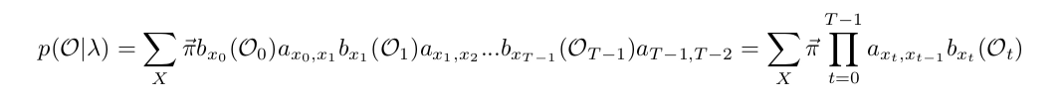

In [109]:
# Naive implementation Hidden Markov Chains
class HiddenMarkovChains:
  def __init__(self, T, E, pi):
    self.T = T # It is a transition matrix A
    self.E = E # It is emission matrix B
    self.pi = pi
    self.states = pi.states
    self.observables = E.observables
  
  def __repr__(self):
    return f"HMM states: {len(self.states)} -> observables: {len(self.observables)}"
  
  @classmethod
  def initialize(cls, states:list, observables: list):
    T = Prob_Mat.initialize(states, states)
    E = Prob_Mat.initialize(states, observables)
    pi = Prob_Vector.initialize(states)
    return cls(T, E, pi)
  
  def _create_all_chains(self, chain_length):
    return list(product((*(self.states,) *chain_length)))
  
  def score(self, observations: list) -> float:
    def mul(x, y): return x * y
    score=0
    all_chains = self._create_all_chains(len(observations))
    for idx, chain in enumerate(all_chains):
      expanded_chain = list(zip(chain, [self.T.states[0]] + list(chain)))
      expanded_obser = list(zip(observations, chain))
      p_observations = list(map(lambda x: self.E.df.loc[x[1], x[0]], expanded_obser))
      p_hidden_state = list(map(lambda x: self.T.df.loc[x[1], x[0]], expanded_chain))
      p_hidden_state[0] = self.pi[chain[0]]
      score += reduce(mul, p_observations) * reduce(mul, p_hidden_state)
    return score

In [7]:
%%time
'''
We are takins use of weather temperature as Hot(1H) and Cold(2C)
then, the relation between annual average temperature and the tree trunk ring sizes: as small(1S), medium(2M) and large(3L)
Here we are taking years where temperature unit was not invented. So, using HMM we are predicting the Hidden markov chain Average Annual Temperature based on tree trunk sizes
'''
a1 = Prob_Vector({'1H':0.7, '2C':0.3})
a2 = Prob_Vector({'1H':0.4, '2C':0.6})
A = Prob_Mat({"1H":a1, "2C":a2})

b1 = Prob_Vector({'1S':0.1, '2M':0.4, '3L':0.5})
b2 = Prob_Vector({'1S':0.7, '2M':0.2, '3L':0.1})
B = Prob_Mat({'1H':b1, '2C':b2})

pi = Prob_Vector({'1H':0.6, '2C':0.4})

hmc = HiddenMarkovChains(A, B, pi)
observations = ['1S', '2M', '3L', '2M', '1S']

print(f"Score for {observations} is {hmc.score(observations):f}")

Score for ['1S', '2M', '3L', '2M', '1S'] is 0.003482
CPU times: user 131 ms, sys: 4.25 ms, total: 136 ms
Wall time: 133 ms


In [21]:
# Verifying the score values for all possible observation chains for a model = 1
all_possible_obs = {"1S", "2M", "3L"}
chain_len = 3
all_observ_chains = list(product(*(all_possible_obs,)* chain_len))
all_pos_score = list(map(lambda obs: hmc.score(obs), all_observ_chains))
print(f"All possible score added: {round(sum(all_pos_score), 1)}")

All possible score added: 1.0


In [110]:
# Forward Pass implementation of Hidden Markov Chains
'''
For the above naive method, the number of calculatoins is 2TN^T multiplications, for finding number of certain observation in chain O
We can use this method to calculate partial observations of sequence up to time t
'''
class HiddenMarkovChains_FP(HiddenMarkovChains):
  def _alphas(self, observations: list) -> np.ndarray:
    alphas = np.zeros((len(observations), len(self.states)))
    alphas[0,:] = self.pi.values * self.E[observations[0]].T
    for t in range(1, len(observations)):
      alphas[t, :] = (alphas[t-1, :].reshape(1, -1) @ self.T.values) * self.E[observations[t]].T
    return alphas
  def score(self, observations:list) -> float:
    alphas = self._alphas(observations)
    return float(alphas[-1].sum())

In [53]:
%%time
hmc_fp = HiddenMarkovChains_FP(A, B, pi)

observ = ['1S', '2M', '3L', '2M', '1S']
# Time taken to calculate the score is 10.8ms whereas in Naive method it has taken 133ms
# Which means this method is 13 times faster than naive mehtod
print(f"Score for {observ} is {hmc_fp.score(observ):f}")

HiddenMarkovChains               1H   2C
probability  0.6  0.4
Score for ['1S', '2M', '3L', '2M', '1S'] is 0.003482
CPU times: user 7.62 ms, sys: 1.84 ms, total: 9.46 ms
Wall time: 10.8 ms


In [52]:
# Verifying the score values for all possible observation chains for a model = 1
all_possible_obs = {"1S", "2M", "3L"}
chain_len = 3
all_observ_chains = list(product(*(all_possible_obs,)* chain_len))
all_pos_score = list(map(lambda obs: hmc_fp.score(obs), all_observ_chains))
print(f"All possible score added: {round(sum(all_pos_score), 1)}")

All possible score added: 1.0


In [111]:
class HiddenMarkovChain_Simulation(HiddenMarkovChains_FP):
  def run(self, length: int) -> (list, list):
    assert length >= 0, "The chain needs to be a non-negative number"
    s_hist = [0] * (length + 1)
    o_hist = [0] * (length + 1)
    prb = self.pi.values
    obs = prb @ self.E.values
    s_hist[0] = np.random.choice(self.states, p=prb.flatten())
    o_hist[0] = np.random.choice(self.observables, p=obs.flatten())
    for t in range(1, length + 1):
      prb = prb @ self.T.values
      obs = prb @ self.E.values
      s_hist[t] = np.random.choice(self.states, p=prb.flatten())
      o_hist[t] = np.random.choice(self.observables, p=obs.flatten())
    return o_hist, s_hist

CPU times: user 42.4 ms, sys: 0 ns, total: 42.4 ms
Wall time: 44.3 ms


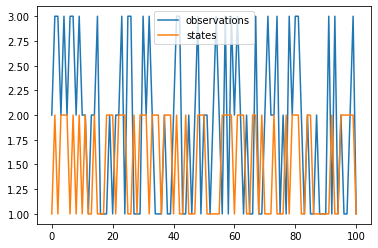

In [59]:
%%time
hmc_s = HiddenMarkovChain_Simulation(A, B, pi)
observation_hist, states_hist = hmc_s.run(100)
length = 100
stats = pd.DataFrame({
    'observations': observation_hist,
    'states': states_hist
}).applymap(lambda x: int(x[0])).plot()

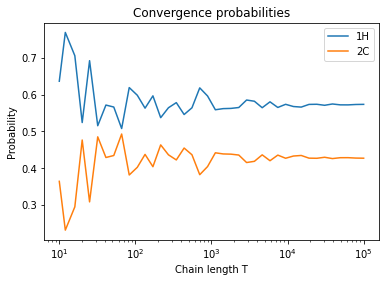

In [63]:
hmc_s = HiddenMarkovChain_Simulation(A, B, pi)

stats = {}
for length in np.logspace(1, 5, 40).astype(int):
  obs_hist, states_hist = hmc_s.run(length)
  stats[length] = pd.DataFrame({
    'observations': obs_hist,
    'states': states_hist
    }).applymap(lambda x: int(x[0]))
S = np.array(list(map(lambda x: x['states'].value_counts().to_numpy()/
                      len(x), stats.values())))

plt.semilogx(np.logspace(1, 5, 40).astype(int), S)
plt.xlabel('Chain length T')
plt.ylabel('Probability')
plt.title('Convergence probabilities')
plt.legend(['1H', '2C'])
plt.show()

In [112]:
class HiddenMarkovChain_Uncover(HiddenMarkovChain_Simulation):
  def _alphas(self, observations: list) -> np.ndarray:
    alphas = np.zeros((len(observations), len(self.states)))
    alphas[0, :] = self.pi.values * self.E[observations[0]].T
    for t in range(1, len(observations)):
      alphas[t, :] = (alphas[t-1, :].reshape(1, -1) @ self.T.values) * self.E[observations[t]].T
    return alphas
    
  def _betas(self, observations: list) -> np.ndarray:
    betas = np.zeros((len(observations), len(self.states))) 
    betas[-1, :] = 1
    for t in range(len(observations) -2, -1, -1):
      betas[t, :] = (self.T.values @ (self.E[observations[t+1]] * betas[t+1,:].reshape(-1, 1))).reshape(1, -1)
    return betas
  
  def uncover(self, observations: list) -> list:
    alphas = self._alphas(observations)
    betas = self._betas(observations)
    maxargs = (alphas * betas).argmax(axis=1)
    return list(map(lambda x: self.states[x], maxargs))

In [67]:
np.random.seed(42)

hmc = HiddenMarkovChain_Uncover(A, B, pi)
observ_seq, latent_seq = hmc.run(5)
uncovered_seq = hmc.uncover(observ_seq)

In [70]:
observ_seq, latent_seq, uncovered_seq

(['3L', '2M', '1S', '3L', '3L', '3L'],
 ['1H', '2C', '1H', '1H', '2C', '1H'],
 ['1H', '1H', '2C', '1H', '1H', '1H'])

In [73]:
all_possible_states = {'1H', '2C'}
chain_length = 6  # any int > 0
all_states_chains = list(product(*(all_possible_states,) * chain_length))

df = pd.DataFrame(all_states_chains)
dfp = pd.DataFrame()

for i in range(chain_length):
    dfp['p' + str(i)] = df.apply(lambda x: 
        hmc.E.df.loc[x[i], observ_seq[i]], axis=1)

scores = dfp.sum(axis=1).sort_values(ascending=False)
df = df.iloc[scores.index]
df['score'] = scores
df.head(10).reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,0,1,2,3,4,5,score
0,55,1H,1H,2C,1H,1H,1H,3.1
1,39,1H,2C,2C,1H,1H,1H,2.9
2,23,2C,1H,2C,1H,1H,1H,2.7
3,53,1H,1H,2C,1H,2C,1H,2.7
4,54,1H,1H,2C,1H,1H,2C,2.7
5,51,1H,1H,2C,2C,1H,1H,2.7
6,63,1H,1H,1H,1H,1H,1H,2.5
7,7,2C,2C,2C,1H,1H,1H,2.5
8,37,1H,2C,2C,1H,2C,1H,2.5
9,35,1H,2C,2C,2C,1H,1H,2.5


In [75]:
dfc = df.copy().reset_index()
for i in range(chain_length):
    dfc = dfc[dfc[i] == latent_seq[i]]

dfc

,index,0,1,2,3,4,5,score
34,45,1H,2C,1H,1H,2C,1H,1.9


In [113]:
class HiddenMarkovLayer(HiddenMarkovChain_Uncover):
    def _digammas(self, observations: list) -> np.ndarray:
        L, N = len(observations), len(self.states)
        digammas = np.zeros((L - 1, N, N))

        alphas = self._alphas(observations)
        betas = self._betas(observations)
        score = self.score(observations)
        for t in range(L - 1):
            P1 = (alphas[t, :].reshape(-1, 1) * self.T.values)
            P2 = self.E[observations[t + 1]].T * betas[t + 1].reshape(1, -1)
            digammas[t, :, :] = P1 * P2 / score
        return digammas

In [114]:
class HiddenMarkovModel:
    def __init__(self, hml: HiddenMarkovLayer):
        self.layer = hml
        self._score_init = 0
        self.score_history = []

    @classmethod
    def initialize(cls, states: list, observables: list):
        layer = HiddenMarkovLayer.initialize(states, observables)
        return cls(layer)

    def update(self, observations: list) -> float:
        alpha = self.layer._alphas(observations)
        beta = self.layer._betas(observations)
        digamma = self.layer._digammas(observations)
        score = alpha[-1].sum()
        gamma = alpha * beta / score 

        L = len(alpha)
        obs_idx = [self.layer.observables.index(x) \
                  for x in observations]
        capture = np.zeros((L, len(self.layer.states), len(self.layer.observables)))
        for t in range(L):
            capture[t, :, obs_idx[t]] = 1.0

        pi = gamma[0]
        T = digamma.sum(axis=0) / gamma[:-1].sum(axis=0).reshape(-1, 1)
        E = (capture * gamma[:, :, np.newaxis]).sum(axis=0) / gamma.sum(axis=0).reshape(-1, 1)

        self.layer.pi = Prob_Vector.from_numpy(pi, self.layer.states)
        self.layer.T = Prob_Mat.from_numpy(T, self.layer.states, self.layer.states)
        self.layer.E = Prob_Mat.from_numpy(E, self.layer.states, self.layer.observables)
            
        return score

    def train(self, observations: list, epochs: int, tol=None):
        self._score_init = 0
        self.score_history = (epochs + 1) * [0]
        early_stopping = isinstance(tol, (int, float))

        for epoch in range(1, epochs + 1):
            score = self.update(observations)
            print("Training... epoch = {} out of {}, score = {}.".format(epoch, epochs, score))
            if early_stopping and abs(self._score_init - score) / score < tol:
                print("Early stopping.")
                break
            self._score_init = score
            self.score_history[epoch] = score

In [115]:
  np.random.seed(42)

observations = ['3L', '2M', '1S', '3L', '3L', '3L']

states = ['1H', '2C']
observables = ['1S', '2M', '3L']

hml = HiddenMarkovLayer.initialize(states, observables)
hmm = HiddenMarkovModel(hml)

hmm.train(observations, 25)

Training... epoch = 1 out of 25, score = 0.0013006714785001687.
Training... epoch = 2 out of 25, score = 0.005509420540117932.
Training... epoch = 3 out of 25, score = 0.005530858882821684.
Training... epoch = 4 out of 25, score = 0.005567116674468162.
Training... epoch = 5 out of 25, score = 0.005630618250468579.
Training... epoch = 6 out of 25, score = 0.005741158382934701.
Training... epoch = 7 out of 25, score = 0.005928044110628503.
Training... epoch = 8 out of 25, score = 0.006225866084209224.
Training... epoch = 9 out of 25, score = 0.006652847604517526.
Training... epoch = 10 out of 25, score = 0.007171787873640834.
Training... epoch = 11 out of 25, score = 0.007683641981602107.
Training... epoch = 12 out of 25, score = 0.008100845554754058.
Training... epoch = 13 out of 25, score = 0.008410987791562236.
Training... epoch = 14 out of 25, score = 0.008650795046039243.
Training... epoch = 15 out of 25, score = 0.008861021470118073.
Training... epoch = 16 out of 25, score = 0.0090

In [116]:
RUNS = 100000
T = 5

chains = RUNS * [0]
for i in range(len(chains)):
    chain = hmm.layer.run(T)[0]
    chains[i] = '-'.join(chain)

In [121]:
chains[:10], len(chains)

(['1S-2M-3L-2M-1S-3L',
  '3L-3L-1S-2M-3L-3L',
  '1S-3L-3L-3L-3L-3L',
  '1S-3L-3L-3L-1S-2M',
  '1S-3L-3L-3L-3L-2M',
  '3L-3L-1S-2M-3L-2M',
  '1S-3L-3L-3L-3L-3L',
  '3L-2M-3L-3L-1S-3L',
  '1S-2M-3L-3L-1S-3L',
  '3L-2M-3L-3L-3L-2M'],
 100000)

In [122]:
df = pd.DataFrame(pd.Series(chains).value_counts(), columns=['counts']).reset_index().rename(columns={'index': 'chain'})
df = pd.merge(df, df['chain'].str.split('-', expand=True), left_index=True, right_index=True)

s = []
for i in range(T + 1):
    s.append(df.apply(lambda x: x[i] == observations[i], axis=1))

df['matched'] = pd.concat(s, axis=1).sum(axis=1)
df['counts'] = df['counts'] / RUNS * 100
df = df.drop(columns=['chain'])
df.head(30)

,counts,0,1,2,3,4,5,matched
0,8.907,3L,3L,3L,3L,3L,3L,4
1,4.422,3L,2M,3L,3L,3L,3L,5
2,4.286,1S,3L,3L,3L,3L,3L,3
3,4.284,3L,3L,3L,3L,3L,2M,3
4,4.278,3L,3L,3L,2M,3L,3L,3
5,4.227,3L,3L,1S,3L,3L,3L,5
6,4.179,3L,3L,3L,3L,1S,3L,3
7,2.179,3L,2M,3L,2M,3L,3L,4
8,2.173,3L,2M,3L,3L,1S,3L,4
9,2.165,1S,3L,1S,3L,3L,3L,4


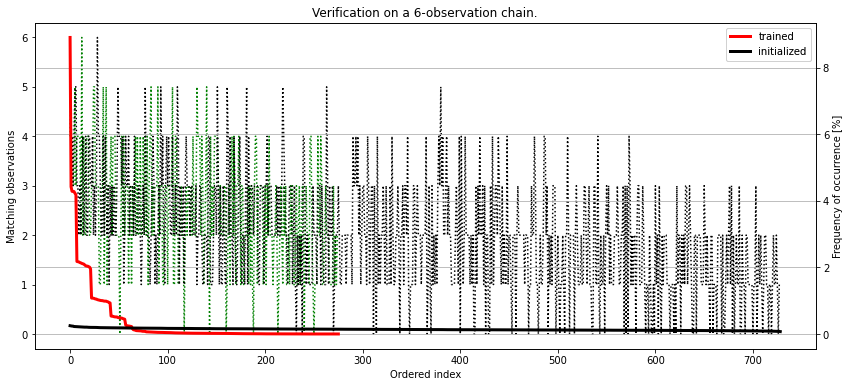

In [123]:
hml_rand = HiddenMarkovLayer.initialize(states, observables)
hmm_rand = HiddenMarkovModel(hml_rand)

RUNS = 100000
T = 5

chains_rand = RUNS * [0]
for i in range(len(chains_rand)):
    chain_rand = hmm_rand.layer.run(T)[0]
    chains_rand[i] = '-'.join(chain_rand)

df2 = pd.DataFrame(pd.Series(chains_rand).value_counts(), columns=['counts']).reset_index().rename(columns={'index': 'chain'})
df2 = pd.merge(df2, df2['chain'].str.split('-', expand=True), left_index=True, right_index=True)

s = []
for i in range(T + 1):
    s.append(df2.apply(lambda x: x[i] == observations[i], axis=1))

df2['matched'] = pd.concat(s, axis=1).sum(axis=1)
df2['counts'] = df2['counts'] / RUNS * 100
df2 = df2.drop(columns=['chain'])

# To verify the quality of our model
# We're plotting the outcomes together with the frequency of occurrence and compare it against a freshly initialized model
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

ax.plot(df['matched'], 'g:')
ax.plot(df2['matched'], 'k:')

ax.set_xlabel('Ordered index')
ax.set_ylabel('Matching observations')
ax.set_title('Verification on a 6-observation chain.')

ax2 = ax.twinx()
ax2.plot(df['counts'], 'r', lw=3)
ax2.plot(df2['counts'], 'k', lw=3)
ax2.set_ylabel('Frequency of occurrence [%]')

ax.legend(['trained', 'initialized'])
ax2.legend(['trained', 'initialized'])

plt.grid()
plt.show()

Result after training of the model. The dotted lines represent the matched sequences. The lines represent the frequency of occurrence for a particular sequence: trained model (red) and freshly initialized (black). The initialized results in almost perfect uniform distribution of sequences, while the trained model gives a strong preference towards the observable sequence.